In [29]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch
import torchvision.transforms as t

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.solvers import OTSolver
from src.plotters import ComponentPlotter
from src.utils import *
from src.costs import InnerGW_opt, InnerGW_const
from src.models.resnet import resnet14_d

from torchvision.datasets import MNIST
# from torchsummary import summary
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.cuda.set_device(2)

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [31]:
data_dim = (1, 32, 32)
p, q = np.prod(data_dim, dtype=int), 2
n_neurons = 128

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = resnet14_d(data_dim, q)

In [21]:
def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    if logger: logger.start()
    try:
        solver = OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                          plotter=plotter, logger=logger, device=DEVICE,
                          **kwargs)
        solver.fit(source, target, n_iter)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()
    return solver

def load_mnist(root, transform=None):
    dataset = MNIST(root, transform=transform, download=True)
    images, targets = [], []
    for image, target in tqdm(dataset):
        images.append(image)
        targets.append(target)
    return torch.stack(images), torch.tensor(targets)

In [22]:
n_components = 10
features, classes = load_mnist("../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
source = TensorDatasetDistribution(features, classes)

U, s, V = torch.pca_lowrank(features.flatten(1), q)

100%|██████████| 60000/60000 [00:05<00:00, 10676.14it/s]


In [9]:
params = dict(
    scales_std=[.1, .4],
    lr=[2e-4, 2e-5],
    n_opt_iter=[2, 10, 20],
    n_inner_iter=[2, 10, 20]
)

In [11]:
from itertools import product

def product_dict(dct):
    for values in product(*dct.values()):
        yield dict(zip(dct.keys(), values))

In [ ]:
for param in product_dict(params):
    locs = 2 * uniform_circle(n_components)
    scales = param["scales_std"] * torch.ones(n_components, q)
    target = gaussian_mixture(locs, scales)

    wandb_logger.start()
    wandb_logger.log_hparams(param)

    solver = run_experiment(
        source, target,
        n_iter=int(1 / param["lr"]),
        n_samples=256,
        cost=InnerGW_opt(
            p, q, 
            optimizer=o.Adam,
            optimizer_params=dict(lr=param["lr"]),
            n_iter=param["n_opt_iter"],
            device=DEVICE
        ),
        plotter=ComponentPlotter(
            source_dim=p,
            target_dim=q,
            pdf_params=dict(
                source_lims=None,
                target_lims=None,
                n_points=500
            ),
        show_progress=True
        ),
        logger=wandb_logger,
        n_inner_iter=param["n_inner_iter"],
        plot_interval=20,
        log_plot_interval=100,
        optimizer_params=dict(lr=param["lr"], weight_decay=1e-10),
    )


<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/50 [00:00<?, ?it/s]

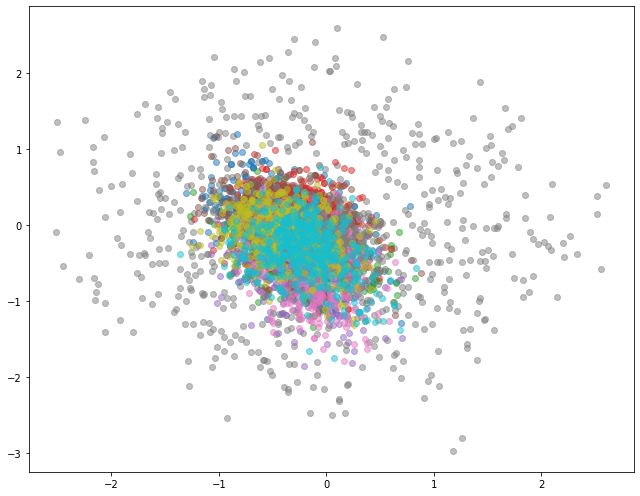

In [40]:
locs = 1.5 * uniform_circle(n_components)
scales = .5 * torch.ones(n_components, q)
target = gaussian_mixture(locs, scales)

# wandb_logger.start(mode="online")

solver = run_experiment(
    source, target,
    n_iter=50,
    n_samples=256,
    cost=InnerGW_opt(
        p, q, 
        optimizer=o.Adam,
        optimizer_params=dict(lr=2e-5, weight_decay=1e-10),
        n_iter=1,
        device=DEVICE
    ),
    # cost=InnerGW_const(V.to(DEVICE)),
    plotter=ComponentPlotter(
        source_dim=p,
        target_dim=q,
        pdf_kind_source=None,
        pdf_kind_target=None,
    ),
    # logger=wandb_logger,
    n_inner_iter=2,
    plot_interval=10,
    # log_plot_interval=250,
    optimizer_params=dict(lr=2e-5, weight_decay=1e-10),
)